# Red Wine Quality Forecasting
Second notebook in analysis of the UCI machine learning red wine dataset  
See my previous exploratory data analysis notebook

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_profiling
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")

## Use pandas profiling to get a quick summary of the data

In [3]:
# Commented out to substantially reduce runtime
#profiling = pandas_profiling.ProfileReport(df)
#profiling.to_file("profiling.html")
#profiling

# Preprocessing
First, lets split the quality target into a binary classification (good vs. bad).  
Good and bad will be split by the average.

In [4]:
avg_qual = df['quality'].mean()

df['quality'] = pd.cut(df['quality'], bins=[0, avg_qual, 10], labels=[0, 1])
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


The mean values and standard deviations of the independent variables vary heavily - we should standardize

## Standardize and divide the dataset into train & test sets for target and variables

In [6]:
from sklearn.model_selection import train_test_split 
target = 'quality'
X = df.drop([target], axis=1)
y = df[target]

from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X = std.fit_transform(X)

# 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# 1. Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

print("Accuracy on test data: ", linreg.score(X_test, y_test))

Accuracy on test data:  0.3071106494075897


The linear regression is quite terrible as expected. Recall the pandas profiling output relationships.

# 2: Logistic Regression

Tuned hyperparameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
Accuracy on test data:  0.7325


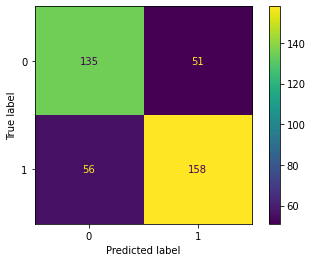

In [8]:
from sklearn.linear_model import LogisticRegression
parameters = {"C": [0.01, 0.1, 1], 'penalty': ['l2'], 'solver': ['sag']}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, parameters, cv=10).fit(X_train, y_train)


print("Tuned hyperparameters: ", logreg_cv.best_params_)
print("Accuracy on test data: ", logreg_cv.score(X_test, y_test))

plot_confusion_matrix(logreg_cv, X_test, y_test)

Not bad  
Model reports a similar amount of false negatives & positives

# 3. Support Vector Machines

Tuned hyperparameters:  {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Accuracy on test data:  0.7375


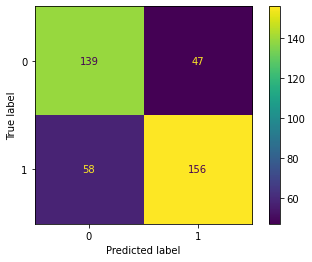

In [9]:
from sklearn.svm import SVC
parameters = {'kernel': ['linear'],
              'C': [1],
              'gamma': [1]}  # Parameters are not iterated upon for computational power limits
svm = SVC()
svm_cv = GridSearchCV(svm, parameters, cv=10).fit(X_train, y_train)
print("Tuned hyperparameters: ", svm_cv.best_params_)
print("Accuracy on test data: ", svm_cv.score(X_test, y_test))

plot_confusion_matrix(svm_cv, X_test, y_test)

# 4. Decision Tree Classifier

Tuned hyperparameters:  {'criterion': 'entropy', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Accuracy on test data:  0.73


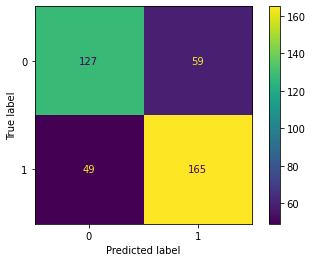

In [10]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10).fit(X_train, y_train)
print("Tuned hyperparameters: ", tree_cv.best_params_)
print("Accuracy on test data: ", tree_cv.score(X_test, y_test))

plot_confusion_matrix(tree_cv, X_test, y_test)

# 5. K-Nearest Neighbors

Tuned hyperparameters:  {'algorithm': 'auto', 'n_neighbors': 1, 'p': 2}
Accuracy on test data:  0.765


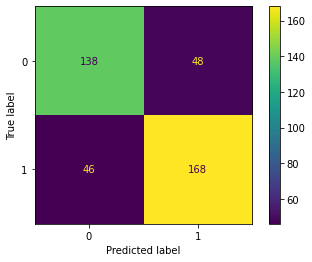

In [11]:
from sklearn.neighbors import KNeighborsClassifier
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=10).fit(X_train, y_train)
print("Tuned hyperparameters: ",knn_cv.best_params_)
print("Accuracy on test data: ",knn_cv.score(X_test, y_test))

plot_confusion_matrix(knn_cv, X_test, y_test)

In [12]:
mod_names = ["Linear Regression", "Logistic Regression", "Support Vector Classifier", "Decision Tree", "k-Nearest Neighbors"]
mods = [linreg, logreg_cv, svm_cv, tree_cv, knn_cv]

scores = [mod.score(X_test, y_test) for mod in mods]

for mod_name, score in zip(mod_names, scores):
    print("Model: ", mod_name)
    print("Score: ", score)
    print("")

Model:  Linear Regression
Score:  0.3071106494075897

Model:  Logistic Regression
Score:  0.7325

Model:  Support Vector Classifier
Score:  0.7375

Model:  Decision Tree
Score:  0.73

Model:  k-Nearest Neighbors
Score:  0.765



knn provides the best prediction accuracy at 76.5%  

-Turner Luke  
Thanks for viewing, keep in touch  
https://www.linkedin.com/in/turnermluke/  
https://github.com/turnerluke  
https://www.kaggle.com/turnerluke  